# Money Management: Stock Price Forecasting Using Long Short Term Memory (LSTM)

LSTM is an tweak version of Recurrent Neural Network which forgets or remembers certain information over a long period of time. In this notebook, I will use LSTM to forecast Google stock price.

Stock price today is probably dependent on:
- The trend it has been folloing from the previous day.
- The price it was traded at from previous day.
- Some other factors that may affect stock price today.

Generalize intuition from above to the following:
- The previous cell state (i.e. the information that was present in the memory after the previous time step).
- The previous hidden state (i.e. this is the same as the output of the previous cell).
- The input at the current time step (i.e. the new information that is being fed in at that moment).

In this notebook, we cover
- Part 1 - Data Preprocessing
- Part 2 - Construct RNN Architecture
- Part 3 - Predictions and Performance Visualization

Source: see [Chapter 11](https://github.com/PacktPublishing/Hands-on-Python-for-Finance/tree/master/Chapter%2011) of **Hands on Python for Finance**

## Recurrent Neural Network (a sequential model)

Given data $X$ and $Y$, we want to feed information forward into a time stamp. Then we form some belief and we make some initial predictions. We investigate our beliefs by looking at the loss function of the initial guesses and the real value. We update our model according to error we observed. 

## Architecture: Feed-forward

Consider data with time stamp
$$X_{\langle 1 \rangle} \rightarrow X_{\langle 2 \rangle} \rightarrow \dots \rightarrow X_{\langle T \rangle}$$
and feed-forward architecture pass information through exactly as the following:
$$
\text{Information in:} \rightarrow
\begin{matrix}
Y_{\langle 1 \rangle}, \hat{Y}_{\langle 1 \rangle} & Y_{\langle 2 \rangle}, \hat{Y}_{\langle 2 \rangle} &       & Y_{\langle T \rangle}, \hat{Y}_{\langle T \rangle} \\
\uparrow               & \uparrow               &       & \uparrow \\
X_{\langle 1 \rangle} \rightarrow    & X_{\langle 2 \rangle} \rightarrow    & \dots \rightarrow & X_{\langle T \rangle} \\
\uparrow               & \uparrow               &       & \uparrow \\
w_{\langle 1 \rangle}, b_{0, \langle 1 \rangle}    & w_{\langle 2 \rangle}, b_{0, \langle 2 \rangle}    &       & w_{\langle T \rangle}, b_{0, \langle T \rangle} \\
\end{matrix}
\rightarrow
\text{Form beliefs about } Y_{\angle T \rangle}
$$
while the educated guesses $\hat{Y}_{\langle T \rangle}$ are our beliefs about real $Y$ at time stamp $T$. 

## Architecture: Feed-backward

Let us clearly define our loss function to make sure we have a proper grip of our mistakes. 
$$\mathcal{L} = \sum_t L(\hat{y}_{\langle t \rangle} - y_t)^2$$
and we can compute the gradient 
$$\triangledown = \frac{\partial \mathcal{L}}{\partial a}$$
and then with respect with parameters $w$ and $b$
$$\frac{\partial \triangledown}{\partial w}, \frac{\partial \triangledown}{\partial a}$$
and now with perspective of where we make our mistakes according to our parameters we can go backward
$$
\text{Information in:} \leftarrow
\underbrace{
\begin{matrix}
Y_{\langle 1 \rangle}, \hat{Y}_{\langle 1 \rangle} & Y_{\langle 2 \rangle}, \hat{Y}_{\langle 2 \rangle} &       & Y_{\langle T \rangle}, \hat{Y}_{\langle T \rangle} \\
\uparrow               & \uparrow               &       & \uparrow \\
X_{\langle 1 \rangle} \leftarrow    & X_{\langle 2 \rangle} \leftarrow    & \dots \leftarrow & X_{\langle T \rangle} \\
\uparrow               & \uparrow               &       & \uparrow \\
w'_{\langle 1 \rangle}, b'_{0, \langle 1 \rangle}    & w'_{\langle 2 \rangle}, b'_{0, \langle 2 \rangle}    &       & w'_{\langle T \rangle}, b'_{0, \langle T \rangle} \\
\end{matrix}}_{\text{Update: } w, b \text{ with } w', b'}
\leftarrow
\text{Total Loss: } \mathcal{L} (\hat{y}, y)
$$
and the *update* action in the above architecture is dependent on your optimizer specified in the algorithm.

### Part 1 - Data Preprocessing

In [1]:
# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Import Data
#!pip install yfinance
import yfinance as yf

In [3]:
ticker = "AAPL"
dataset_train = yf.download(ticker)

[*********************100%***********************]  1 of 1 completed


In [4]:
dataset_train.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-19,143.750000,144.070007,141.669998,142.449997,142.449997,121434600
2021-07-20,143.460007,147.100006,142.960007,146.149994,146.149994,96238600
2021-07-21,145.529999,146.130005,144.630005,145.399994,145.399994,74915000
2021-07-22,145.940002,148.199997,145.809998,146.800003,146.800003,77338200
2021-07-23,147.550003,148.720001,146.919998,148.559998,148.559998,71361600


In [5]:
# Preview
print(dataset_train.head())
print(dataset_train.tail())

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
1980-12-12  0.128348  0.128906  0.128348  0.128348   0.100751  469033600
1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095495  175884800
1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088485  105728000
1980-12-17  0.115513  0.116071  0.115513  0.115513   0.090676   86441600
1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093304   73449600
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-07-19  143.750000  144.070007  141.669998  142.449997  142.449997   
2021-07-20  143.460007  147.100006  142.960007  146.149994  146.149994   
2021-07-21  145.529999  146.130005  144.630005  145.399994  145.399994   
2021-07-22  145.940002  148.199997  145.809998  146.800003  146.800003   
2021-07-23  147.550003  148.720001  146.91999

In [6]:
# Select Open Column
training_set = dataset_train.iloc[:, 1:2].values
print(training_set)

[[1.28905997e-01]
 [1.22210003e-01]
 [1.13280997e-01]
 ...
 [1.46130005e+02]
 [1.48199997e+02]
 [1.48720001e+02]]


In [7]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

In [8]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [9]:
training_set_scaled

array([[5.28448278e-04],
       [4.83793538e-04],
       [4.24247111e-04],
       ...,
       [9.74191487e-01],
       [9.87996005e-01],
       [9.91463848e-01]])

In [10]:
X_train = []
y_train = []

In [11]:
# Creating a data structure with 100 timesteps and 1 output. 1258 is the total number of records in the Open column
for i in range(100, 1258):
    X_train.append(training_set_scaled[i-100:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [12]:
X_train.shape

(1158, 100)

In [13]:
y_train.shape

(1158,)

In [14]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1158, 100, 1)

### Part 2 - Building RNN

In [15]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [16]:
# Initialize RNN
regressor = Sequential()

In [17]:
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

In [18]:
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [19]:
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [20]:
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [21]:
# Adding the output layer
regressor.add(Dense(units = 1))

In [22]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [23]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [24]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 20, batch_size = 64)
# Comment:
# Originally, the batch_size was set 32 in the ipynb provided by the authors.
# I changed it to 64. This is because I believe for Google a sequence of 32 is not enough.
# My intuition is confirmed. If you use 32, you will observe a larger test error.

Epoch 1/20
19/19 [==============================] - 3s 162ms/step - loss: 8.5232e-05
Epoch 2/20
19/19 [==============================] - 3s 152ms/step - loss: 4.6858e-06
Epoch 3/20
19/19 [==============================] - 3s 148ms/step - loss: 9.0705e-07
Epoch 4/20
19/19 [==============================] - 2s 121ms/step - loss: 2.5774e-07
Epoch 5/20
19/19 [==============================] - 2s 118ms/step - loss: 1.7966e-07
Epoch 6/20
19/19 [==============================] - 2s 121ms/step - loss: 1.4699e-07
Epoch 7/20
19/19 [==============================] - 2s 120ms/step - loss: 1.2916e-07
Epoch 8/20
19/19 [==============================] - 2s 122ms/step - loss: 1.2745e-07
Epoch 9/20
19/19 [==============================] - 3s 141ms/step - loss: 1.2669e-07
Epoch 10/20
19/19 [==============================] - 3s 158ms/step - loss: 1.2213e-07
Epoch 11/20
19/19 [==============================] - 3s 154ms/step - loss: 1.1991e-07
Epoch 12/20
19/19 [==============================] - 3s 155ms/s

### Part 3 - Making the predictions and visualising the results

In [25]:
dataset_train.iloc[10000::,1]

Date
2020-08-11    112.482498
2020-08-12    113.275002
2020-08-13    116.042503
2020-08-14    115.000000
2020-08-17    116.087502
                 ...    
2021-07-19    144.070007
2021-07-20    147.100006
2021-07-21    146.130005
2021-07-22    148.199997
2021-07-23    148.720001
Name: High, Length: 240, dtype: float64

In [26]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of later years
dataset_test = dataset_train.iloc[10000::,:]

In [27]:
dataset_test.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-19,143.750000,144.070007,141.669998,142.449997,142.449997,121434600
2021-07-20,143.460007,147.100006,142.960007,146.149994,146.149994,96238600
2021-07-21,145.529999,146.130005,144.630005,145.399994,145.399994,74915000
2021-07-22,145.940002,148.199997,145.809998,146.800003,146.800003,77338200
2021-07-23,147.550003,148.720001,146.919998,148.559998,148.559998,71361600


In [28]:
real_stock_price = dataset_test.iloc[:, 1:2].values

# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 100:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
inputs.shape

(340, 1)

In [29]:
for i in range(100, 330):
    X_test.append(inputs[i-100:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [30]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [31]:
print(X_train.shape)
print(X_test.shape)

(1158, 100, 1)
(230, 100, 1)


In [32]:
predicted_stock_price[:6]

array([[0.6167224 ],
       [0.61884385],
       [0.6238812 ],
       [0.6322889 ],
       [0.64408636],
       [0.6587834 ]], dtype=float32)

In [33]:
predicted_stock_price = abs(predicted_stock_price) * 190

In [34]:
predicted_stock_price[:6]

array([[117.17725],
       [117.58033],
       [118.53743],
       [120.13489],
       [122.37641],
       [125.16884]], dtype=float32)

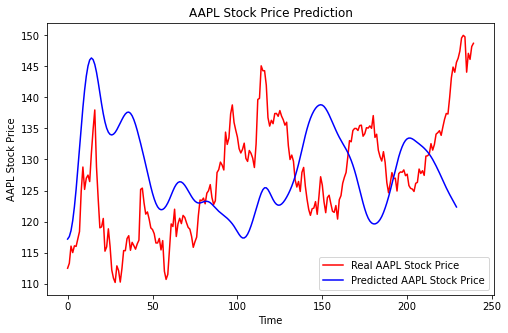

In [35]:
# Visualising the results
plt.figure(figsize=(8,5))
plt.plot(real_stock_price, color = 'red', label = 'Real ' + ticker + ' Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted ' + ticker + ' Stock Price')
plt.title(ticker + ' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(ticker + ' Stock Price')
plt.legend()
plt.show()

In [36]:
import math
from sklearn.metrics import mean_squared_error

In [37]:
real_stock_price.shape

(240, 1)

In [38]:
predicted_stock_price.shape

(230, 1)

In [55]:
real_stock_price.shape

(240, 1)

In [56]:
predicted_stock_price

array([[117.17725 ],
       [117.58033 ],
       [118.53743 ],
       [120.13489 ],
       [122.37641 ],
       [125.16884 ],
       [128.36096 ],
       [131.75551 ],
       [135.15431 ],
       [138.35968 ],
       [141.16411 ],
       [143.43105 ],
       [145.06622 ],
       [146.03305 ],
       [146.35663 ],
       [146.09718 ],
       [145.31683 ],
       [144.06981 ],
       [142.4811  ],
       [140.71324 ],
       [138.95903 ],
       [137.37035 ],
       [136.04259 ],
       [135.0456  ],
       [134.39276 ],
       [134.04466 ],
       [133.95244 ],
       [134.07545 ],
       [134.36496 ],
       [134.79991 ],
       [135.32117 ],
       [135.8758  ],
       [136.42972 ],
       [136.93723 ],
       [137.33855 ],
       [137.5843  ],
       [137.63446 ],
       [137.45128 ],
       [137.03908 ],
       [136.41753 ],
       [135.61716 ],
       [134.6839  ],
       [133.65712 ],
       [132.5794  ],
       [131.46886 ],
       [130.31699 ],
       [129.13243 ],
       [127.9

In [49]:
rmse = np.sqrt(mean_squared_error(real_stock_price[~np.isnan(real_stock_price)], predicted_stock_price))
print(f'Root Mean Square Error is {round(rmse,2)} for test set.')
print(f'Interpretation: ---------------')
print(f'On the test set, the performance of this LSTM architecture guesses Google stock price \non average within the error of ${round(rmse,2)} dollars.')

ValueError: Found input variables with inconsistent numbers of samples: [240, 230]